# 1. Importing and Understanding Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from datetime import date, datetime
import time
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import holidays
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [3]:
holiday_path = "/content/drive/MyDrive/capstone/holidays_events.csv"
store_path = "/content/drive/MyDrive/capstone/stores.csv"
train_path = "/content/drive/MyDrive/capstone/train.csv"
test_path = "/content/drive/MyDrive/capstone/test.csv"
oil_path = "/content/drive/MyDrive/capstone/oil.csv"

## 1.1 Holiday Data

In [4]:
holiday_df = pd.read_csv(holiday_path)
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
holiday_df.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

In [6]:
holiday_df["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [7]:
holiday_df.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

## 1.2 Sales Data

In [8]:
sales_df = pd.read_csv(train_path)
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
sales_df['date'] = pd.to_datetime(sales_df['date'], format="%Y-%m-%d")
holiday_df['date'] = pd.to_datetime(holiday_df['date'], format="%Y-%m-%d")

## 1.3 Store Data

In [10]:
store_df = pd.read_csv(store_path)
store_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


As we know, highest selling Family is Grocery-I and highest selling store is store 44.

In [11]:
store_df[store_df.store_nbr==44]

,store_nbr,city,state,type,cluster
43,44,Quito,Pichincha,A,5


In [12]:
store_df[store_df.type=="A"]

,store_nbr,city,state,type,cluster
43,44,Quito,Pichincha,A,5
44,45,Quito,Pichincha,A,11
45,46,Quito,Pichincha,A,14
46,47,Quito,Pichincha,A,14
47,48,Quito,Pichincha,A,14
48,49,Quito,Pichincha,A,11
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11


In [13]:
store_df.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

# 2. Data Preprocessing

## 2.1 Combining holidays data with sales data

In [14]:
sales_df = sales_df.merge(holiday_df[["date","type","locale","transferred"]], on=["date"])
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,False
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,False


##2.2 Combining sales data with store data

In [15]:
sales_df = sales_df.merge(store_df[["store_nbr","city","state","type","cluster"]], on=["store_nbr"],suffixes=('_date', '_store'))
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion,type_date,locale,transferred,city,state,type_store,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,False,Quito,Pichincha,D,13


## 2.3 Rectifying Column data types

In [16]:
sales_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
type_date              object
locale                 object
transferred              bool
city                   object
state                  object
type_store             object
cluster                 int64
dtype: object

In [17]:
sales_df['date'] = pd.to_datetime(sales_df['date'], format="%Y-%m-%d")

In [20]:
sales_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
type_date              object
locale                 object
transferred              bool
city                   object
state                  object
type_store             object
cluster                 int64
dtype: object

In [21]:
sales_df_grocery = sales_df[sales_df["family"] == "GROCERY I"]
sales_df_grocery = sales_df_grocery[sales_df_grocery["store_nbr"]==44]

## 2.4  Adding features related to Time dimension

In [22]:
def preprocess_df(pdf):
  pdf['week_no'] = pdf['date'].apply(lambda x: x.isocalendar()[1])
  pdf['month_no'] = pdf['date'].apply(lambda x: int(x.strftime("%m")))
  pdf['year'] = pdf['date'].apply(lambda x: x.isocalendar()[0])
  pdf['day_of_month'] = pdf['date'].dt.day
  pdf['day_of_week'] = pdf['date'].apply(lambda x: x.isocalendar()[2])
  pdf['day_of_year'] = pdf['date'].apply(lambda x: int(x.strftime("%j")))

  return pdf, ["week_no", "month_no", "year", "day_of_week", "day_of_year","day_of_month"]

In [23]:
sales_df_grocery, time_cols = preprocess_df(sales_df_grocery)
sales_df_grocery.head()

,id,date,store_nbr,family,sales,onpromotion,type_date,locale,transferred,city,state,type_store,cluster,week_no,month_no,year,day_of_month,day_of_week,day_of_year
353640,1266,2013-01-01,44,GROCERY I,0.0,0,Holiday,National,False,Quito,Pichincha,A,5,1,1,2013,1,2,1
353673,8394,2013-01-05,44,GROCERY I,10699.0,0,Work Day,National,False,Quito,Pichincha,A,5,1,1,2013,5,6,5
353706,20868,2013-01-12,44,GROCERY I,8294.0,0,Work Day,National,False,Quito,Pichincha,A,5,2,1,2013,12,6,12
353739,74328,2013-02-11,44,GROCERY I,5790.0,0,Holiday,National,False,Quito,Pichincha,A,5,7,2,2013,11,1,42
353772,76110,2013-02-12,44,GROCERY I,7601.0,0,Holiday,National,False,Quito,Pichincha,A,5,7,2,2013,12,2,43


In [24]:
selected_cols = ["date","sales","type_date","locale","transferred"] + time_cols
sales_df_grocery = sales_df_grocery[selected_cols]

In [25]:
sales_df_grocery.sort_values(by="date",inplace = True)
sales_df_grocery.head(2)

,date,sales,type_date,locale,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month
353640,2013-01-01,0.0,Holiday,National,False,1,1,2013,2,1,1
353673,2013-01-05,10699.0,Work Day,National,False,1,1,2013,6,5,5


Adding LY sales as a column

In [26]:
sales_df_grocery_copy = sales_df_grocery.copy()
sales_df_grocery_copy['year'] = sales_df_grocery_copy['year'] + 1
sales_df_grocery["ly_sales"] = sales_df_grocery.drop('sales', axis=1).merge(sales_df_grocery_copy, on = ["day_of_year","year"])["sales"]
sales_df_grocery.head()

,date,sales,type_date,locale,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month,ly_sales
353640,2013-01-01,0.0,Holiday,National,False,1,1,2013,2,1,1,NaN
353673,2013-01-05,10699.0,Work Day,National,False,1,1,2013,6,5,5,NaN
353706,2013-01-12,8294.0,Work Day,National,False,2,1,2013,6,12,12,NaN
353739,2013-02-11,5790.0,Holiday,National,False,7,2,2013,1,42,11,NaN
353772,2013-02-12,7601.0,Holiday,National,False,7,2,2013,2,43,12,NaN


In [27]:
sales_df_grocery['ly_sales'] = sales_df_grocery['ly_sales'].fillna(0)
sales_df_grocery.head()

,date,sales,type_date,locale,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month,ly_sales
353640,2013-01-01,0.0,Holiday,National,False,1,1,2013,2,1,1,0.0
353673,2013-01-05,10699.0,Work Day,National,False,1,1,2013,6,5,5,0.0
353706,2013-01-12,8294.0,Work Day,National,False,2,1,2013,6,12,12,0.0
353739,2013-02-11,5790.0,Holiday,National,False,7,2,2013,1,42,11,0.0
353772,2013-02-12,7601.0,Holiday,National,False,7,2,2013,2,43,12,0.0


## 2.5 Removing null values and outliers

In [28]:
sales_df_grocery.sales.isna().sum()

0

In [29]:
sum(sales_df_grocery["sales"] != 0)

277

In [30]:
# removing 0 sales day
sales_df_grocery = sales_df_grocery[sales_df_grocery["sales"] != 0]

## 2.6 One-hot encoding categorical varibales

In [31]:
def one_hot_encode(df, col):
  one_hot = pd.get_dummies(df[col])
  # Drop col as it is now encoded
  df = df.drop(col,axis = 1)
  df = df.join(one_hot)
  return df  

In [32]:
# one-hot encoding categorical variables
sales_df_grocery = one_hot_encode(sales_df_grocery,"type_date")
sales_df_grocery = one_hot_encode(sales_df_grocery,"locale")
# sales_df_grocery = one_hot_encode(sales_df_grocery,"transferred")

In [33]:
sales_df_grocery.head()

,date,sales,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month,ly_sales,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,National,Regional
353673,2013-01-05,10699.0,False,1,1,2013,6,5,5,0.0,0,0,0,0,0,1,0,1,0
353706,2013-01-12,8294.0,False,2,1,2013,6,12,12,0.0,0,0,0,0,0,1,0,1,0
353739,2013-02-11,5790.0,False,7,2,2013,1,42,11,0.0,0,0,0,1,0,0,0,1,0
353772,2013-02-12,7601.0,False,7,2,2013,2,43,12,0.0,0,0,0,1,0,0,0,1,0
353805,2013-03-02,11514.0,False,9,3,2013,6,61,2,0.0,0,0,0,1,0,0,1,0,0


# 3. Test-Train Split

Testing on last 1 year of data at a store and Family level per unit

Train_df

In [34]:
# train_df contains data till 2017 July
train_df = sales_df_grocery[sales_df_grocery["date"] < "2016-08-01"]
train_df.tail()

,date,sales,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month,ly_sales,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,National,Regional
360814,2016-07-03,15583.0,False,26,7,2016,7,185,3,0.0,0,0,0,1,0,0,1,0,0
360867,2016-07-23,11488.0,False,29,7,2016,6,205,23,0.0,0,0,0,1,0,0,1,0,0
360913,2016-07-24,11469.0,False,29,7,2016,7,206,24,0.0,0,0,0,0,1,0,1,0,0
360912,2016-07-24,11469.0,False,29,7,2016,7,206,24,0.0,1,0,0,0,0,0,1,0,0
360966,2016-07-25,8303.0,True,30,7,2016,1,207,25,0.0,0,0,0,1,0,0,1,0,0


Test_df

In [35]:
# train_df contains data for last 1 year i.e Aug'16 to Aug'17 
test_df = sales_df_grocery[sales_df_grocery["date"] >= "2016-08-01"]
test_df.head()

,date,sales,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month,ly_sales,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,National,Regional
360999,2016-08-05,9171.0,False,31,8,2016,5,218,5,0.0,0,0,0,1,0,0,1,0,0
361032,2016-08-10,8039.0,True,32,8,2016,3,223,10,0.0,0,0,0,1,0,0,0,1,0
361065,2016-08-12,10125.0,False,32,8,2016,5,225,12,0.0,0,0,0,0,1,0,0,1,0
361098,2016-08-15,8493.0,False,33,8,2016,1,228,15,0.0,0,0,0,1,0,0,1,0,0
361131,2016-08-24,8382.0,False,34,8,2016,3,237,24,0.0,0,0,0,1,0,0,1,0,0


Removing date now, as filtering done and date cannot be passed into the models. Instead it has been decomposed into time dimensions features

In [36]:
train_df.drop(["date"], axis=1,inplace = True)
test_df.drop(["date"], axis=1,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
y_train = train_df[["sales"]]
x_train = train_df[[i for i in train_df.columns if i !="sales"]]
y_test = test_df[["sales"]]
x_test = test_df[[i for i in train_df.columns if i !="sales"]]

In [38]:
x_train.shape

(219, 17)

In [39]:
x_test.shape

(58, 17)

# 4. Modelling

## 4.1 XGBoost

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[16:13:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

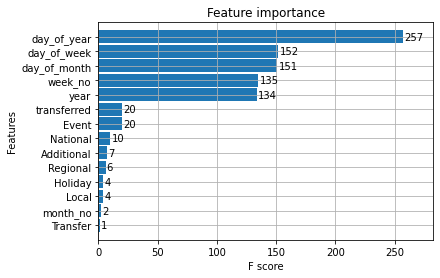

In [41]:
_ = plot_importance(reg, height=0.9)

In [42]:
y_pred = reg.predict(x_test)
y_pred[5]

8319.405

In [43]:
test_df['sales_prediction'] = y_pred
all_sales_df = pd.concat([test_df, train_df], sort=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
subset_sales = all_sales_df[all_sales_df["year"]>2015]

In [45]:
dates = []
for index, row in subset_sales.iterrows():
  d = date(int(row['year']),int(row['month_no']),int(row['day_of_month'])).isoformat()
  dates.append(d)
subset_sales['date'] = dates
subset_sales.sort_values(by=["date"],inplace=True)
subset_sales.set_index("date", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
subset_sales.head()

,sales,transferred,week_no,month_no,year,day_of_week,day_of_year,day_of_month,ly_sales,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,National,Regional,sales_prediction
date,,,,,,,,,,,,,,,,,,,
2016-02-08,8845.0,False,6,2,2016,1,39,8,0.0,0,0,0,1,0,0,0,1,0,NaN
2016-02-09,11578.0,False,6,2,2016,2,40,9,0.0,0,0,0,1,0,0,0,1,0,NaN
2016-03-02,10909.0,False,9,3,2016,3,62,2,0.0,0,0,0,1,0,0,1,0,0,NaN
2016-03-25,8871.0,False,12,3,2016,5,85,25,0.0,0,0,0,1,0,0,0,1,0,NaN
2016-04-01,10013.0,False,13,4,2016,5,92,1,0.0,0,0,0,1,0,0,0,0,1,NaN


<Figure size 432x288 with 0 Axes>

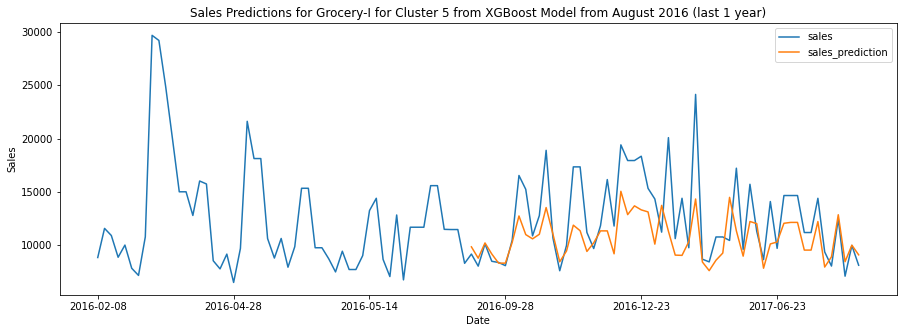

In [47]:
plt.figure()
subset_sales[['sales','sales_prediction']].plot(figsize=(15, 5))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Predictions for Grocery-I for Cluster 5 from XGBoost Model from August 2016 (last 1 year)")
plt.show()

In [48]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [49]:
mape(y_test, y_pred)

26.4065130478286

In [50]:
(y_test==0).sum()

sales    0
dtype: int64

## 4.2 Random Forest

In [51]:
model = RandomForestRegressor(n_estimators=1000)
model.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_estimators=1000)

In [52]:
y_pred = model.predict(x_test)

In [53]:
test_df['sales_prediction_rf'] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
all_sales_rf_df = pd.concat([test_df, train_df], sort=False)
all_sales_rf_df.columns

Index(['sales', 'transferred', 'week_no', 'month_no', 'year', 'day_of_week',
       'day_of_year', 'day_of_month', 'ly_sales', 'Additional', 'Bridge',
       'Event', 'Holiday', 'Transfer', 'Work Day', 'Local', 'National',
       'Regional', 'sales_prediction', 'sales_prediction_rf'],
      dtype='object')

In [55]:
subset_sales_rf = all_sales_rf_df[all_sales_rf_df.year>2015]

In [56]:
dates = []
for index, row in subset_sales_rf.iterrows():
  d = date(int(row['year']),int(row['month_no']),int(row['day_of_month'])).isoformat()
  dates.append(d)
subset_sales_rf['date'] = dates
subset_sales_rf.sort_values(by=["date"],inplace=True)
subset_sales_rf.set_index("date", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 432x288 with 0 Axes>

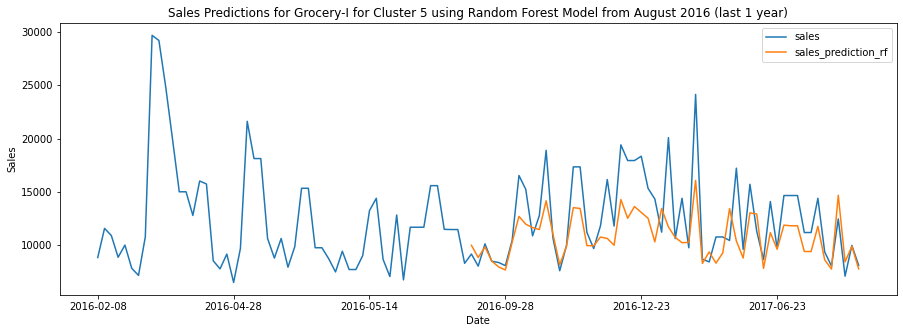

In [57]:
plt.figure()
subset_sales_rf[['sales','sales_prediction_rf']].plot(figsize=(15, 5))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Predictions for Grocery-I for Cluster 5 using Random Forest Model from August 2016 (last 1 year)")
plt.show()

In [58]:
mape(y_test, y_pred)

26.956127116024387

----Finish-----